## TEST BOUNDARY OF **2000Q** (TSP QUBO)
![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQGuNq9SVIrMNopSCKdspSK1Kd5MumNS707FYWzqKwmwg&s)

In [1]:
import numpy
print(numpy.__version__)

1.26.4


In [2]:
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.manifold import MDS

def tsp_example(points):
    np.random.seed(42)
    df=pd.DataFrame({'x': np.random.randint(0, 10000, points), 'y': np.random.randint(0, 10000, points)})
    return df

### เก็บค่า `original_dist` (ORIGINAL_DISTANCE_MATRIX) เพื่อเขาไว้เป็น baseline ในการคำนวณ

In [3]:
N_test = 8  # ลองเริ่มจาก 10 ... จนถึง 17 nodes ที่รัน 2000Q ไม่ได้
df = tsp_example(N_test)
d=distance_matrix(df[['x', 'y']].values, df[['x', 'y']].values, 2)

### Draw problem state

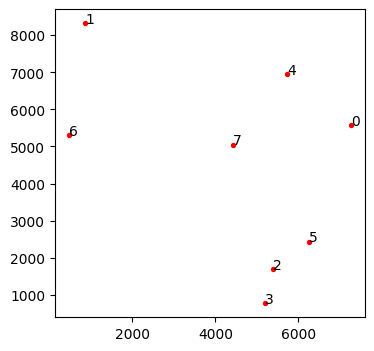

In [4]:
plt.figure(figsize=(4, 4))

for i in range(len(df)):
    plt.scatter(df.iloc[i]['x'], df.iloc[i]['y'], c='red', s=8)
    plt.text(df.iloc[i]['x']+0.01, df.iloc[i]['y']+0.01, f'{i}')

plt.show()

### QUBO Building

In [5]:
class QuboPoly():
    def __init__(self, n=1024):
        self.array=np.zeros((n, n), dtype=int)
        self.constant=0
        self._size=n
    
    def add_term(self, i, j, c):
        if i>=self._size or j>=self._size:
            raise RuntimeError("Wrong index")
        self.array[i][j]+=c
        
    def add_constant(self, c):
        self.constant+=c
        
    def sum(self, p):
        if self._size != p._size:
            raise RuntimeError("Wrong polynomial size")
        self.array+=p.array
        self.constant+=p.constant
        
    def power(self):
        a=np.diag(self.array)
        self.array=np.outer(a, a) + 2*self.constant*np.diag(a) # convert back to NxN
        self.constant**=2
        
    def multiply(self, p):
        a=np.diag(self.array)
        b=np.diag(p.array)
        self.array=np.outer(a, b) + self.constant*np.diag(b) + p.constant*np.diag(a)
        self.constant*=p.constant

##### $ Obj=\sum_{t=0}^{time-1}\sum_{i=0}^{city}\sum_{j=0}^{city}x_{i,t}\cdot x_{j,t+1}\cdot d_{i,j} + \sum_{i=0}^{city}\sum_{j=0}^{city}x_{i,t_{end}}\cdot x_{j,0}\cdot d_{i,j} $ (last terms for calculating Hamiltonian cycle)

In [6]:
def objective_function():
    qubo=QuboPoly(n_point*time_step)
    # Ex. 3 cities iterate 0 1 2-> (0,1) (0,2) (2,0)
    for t in range(time_step):
        for i in range(n_point):
            for j in range(n_point):
                #print(city_index[i], city_index[j], t)
                if t==time_step-1: 
                    qubo.add_term((i*time_step)+t, (j*time_step), d[i][j])  # last terms that the final destination reaches the original node
                else:
                    qubo.add_term((i*time_step)+t, (j*time_step)+t+1, d[i][j])
    #print(qubo.array)
    return qubo

##### $ C_{1}=\sum_{t=0}^{time}(\sum_{i=0}^{city} x_{i, t}-1)^2 $ (one-hot constraint for column)

In [7]:
def build_one_car_each_t(alpha):
    qubo=QuboPoly(n_point*time_step)
    for t in range(time_step):
        tmp=QuboPoly(n_point*time_step)
        for i in range(n_point):
            #print((i*time_step)+t, t)
            tmp.add_term((i*time_step)+t, (i*time_step)+t, alpha)
        tmp.add_constant(-alpha)
        tmp.power()
        qubo.sum(tmp)
        #print(tmp.array)
    #print(qubo.array)
    return qubo

##### $ C_{2}=\sum_{i=0}^{city}(\sum_{t=0}^{time} x_{i, t}-1)^2 $ (one-hot constraint for row)

In [8]:
def build_car_visit_once(alpha):
    qubo=QuboPoly(n_point*time_step)
    for i in range(n_point):
        tmp=QuboPoly(n_point*time_step)
        for t in range(time_step):
            #print((i*time_step)+t, t)
            tmp.add_term((i*time_step)+t, (i*time_step)+t, alpha)
        tmp.add_constant(-alpha)
        tmp.power()
        qubo.sum(tmp)
        #print(tmp.array)
    #print(qubo.array)
    return qubo

#### Building $Q$ matrix

In [9]:
from time import monotonic
start_time=monotonic()  # timer

n_point, time_step=N_test, N_test
Q=QuboPoly(N_test**2)
Obj=objective_function()
C1=build_one_car_each_t(500) # column-alpha
C2=build_car_visit_once(500) # row-alpha
Q.sum(Obj)
Q.sum(C1)
Q.sum(C2)

print(f"Gen. Q time {monotonic() - start_time} seconds")
print("constant =", Q.constant)
#print(Q.array)
print(f"Matrix size: {Q._size} x {Q._size}")

Gen. Q time 0.002807708000545972 seconds
constant = 4000000
Matrix size: 64 x 64


In [10]:
from collections import defaultdict
Q_dwave=defaultdict(int)

for i in range(Q._size):
    for j in range(Q._size):
        if Q.array[i, j]!=0:
            Q_dwave[(i, j)]=Q.array[i, j]

print("# of terms =", len(Q_dwave))
print("# of total =", Q._size**2)
print(f'Terms = {len(Q_dwave)/(Q._size**2)}%')

# of terms = 1408
# of total = 4096
Terms = 0.34375%


### Solve $x^TQx$ via D'Wave QM

In [11]:
from dwave.system import DWaveSampler, EmbeddingComposite, LeapHybridSampler, CutOffComposite, AutoEmbeddingComposite
from dimod import BinaryQuadraticModel
import dwave_networkx as dnx
import time

bqm=BinaryQuadraticModel.from_qubo(Q_dwave)

## **Quantum Annealer 2000Q**

In [12]:
start_time=monotonic()

bqm_sampler=EmbeddingComposite(DWaveSampler())
sampleset=bqm_sampler.sample(bqm, label=f'Nodes = {N_test}', num_reads=1000)

#bqm_sampler=CutOffComposite(AutoEmbeddingComposite(DWaveSampler(solver={'qpu': True})), cutoff=0.75)
#sampleset=bqm_sampler.sample(bqm, label=f'2000Q-7-TSP', num_reads=num_reads)

print(f"D-wave time {monotonic()-start_time} seconds")

D-wave time 16.416164583000864 seconds


In [13]:
print(sampleset.info)

{'timing': {'qpu_sampling_time': 143040.0, 'qpu_anneal_time_per_sample': 20.0, 'qpu_readout_time_per_sample': 102.46, 'qpu_access_time': 158799.97, 'qpu_access_overhead_time': 3179.03, 'qpu_programming_time': 15759.97, 'qpu_delay_time_per_sample': 20.58, 'post_processing_overhead_time': 51.0, 'total_post_processing_time': 51.0}, 'problem_id': '0c213312-b7c4-438b-8cec-9c4124292e79', 'problem_label': 'Nodes = 8'}


In [14]:
best_sample=sampleset.first.sample
best_energy=sampleset.first.energy

print("Best Sample:", best_sample)
print("Best Energy:", best_energy)

# map it back to answer
solution=np.zeros(n_point*time_step, dtype=int)
for index, var in enumerate(best_sample):
    solution[index]=int(best_sample[var])

Best Sample: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 1, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 1, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 1, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 1, 48: 1, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 1, 63: 0}
Best Energy: -3954397.0


In [15]:
#import sys
#np.set_printoptions(threshold=sys.maxsize)
#print(solution.reshape(n_point, time_step))
solution=solution.reshape(n_point, time_step)
print(solution)

[[0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]]


In [16]:
def check_c1():
    for t in range(time_step):
        cnt=0
        for i in range(n_point):
            cnt+=solution[i][t]
        if cnt!=1:
            return False
    return True

def check_c2():
    for i in range(n_point):
        cnt=0
        for t in range(time_step):
            cnt+=solution[i][t]
        if cnt!=1:
            return False
    return True

In [17]:
routes=[0]*time_step
for index, (key, val) in enumerate(best_sample.items()):
    #print(index, key, val)
    if val > 0.5:
        print(f'x{index} = {val} (city: {int(index/time_step)}, time: {index%time_step})')
        routes[index%time_step]=int(index/time_step)

# append for drawing graph with Hamiltonian cycle by hand
routes.append(routes[0])
print(routes)
print("Number of visited:", len(routes))
print("Number of unique:", len(set(routes)))
print("C1:", check_c1())
print("C2:", check_c2())

x5 = 1 (city: 0, time: 5)
x12 = 1 (city: 1, time: 4)
x19 = 1 (city: 2, time: 3)
x25 = 1 (city: 3, time: 1)
x34 = 1 (city: 4, time: 2)
x47 = 1 (city: 5, time: 7)
x48 = 1 (city: 6, time: 0)
x62 = 1 (city: 7, time: 6)
[6, 3, 4, 2, 1, 0, 7, 5, 6]
Number of visited: 9
Number of unique: 8
C1: True
C2: True


#### Visualization

Total cost: 45606.954283665385


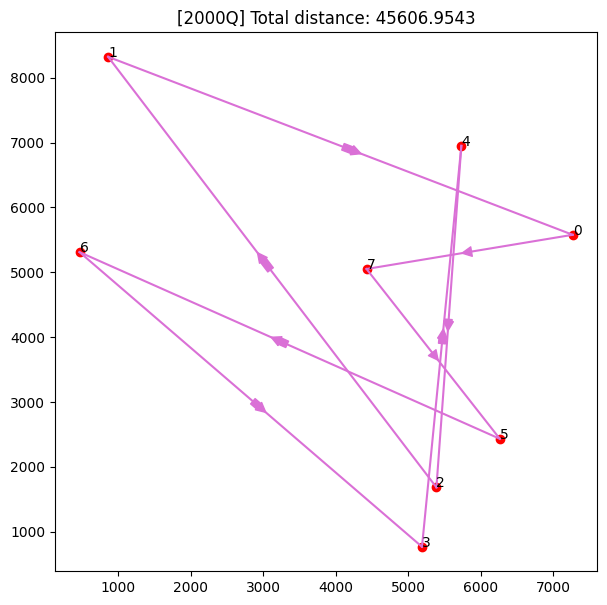

In [30]:
plt.figure(figsize=(7, 7))

cost = 0
for i in range(len(routes)-1):
    cost += d[routes[i]][routes[i+1]]  # DON'T FORGET TO USE THE ORIGINAL_DISTANCE_MATRIX EVERYTIME YOU MAPPED BACK TO THE ANSWER
print("Total cost:", cost)

for i in range(len(d[0])):
    plt.scatter(df.iloc[i]['x'], df.iloc[i]['y'], c='red')
    plt.text(df.iloc[i]['x']+0.88, df.iloc[i]['y']+0.88, f'{i}')

for i in range(len(routes)-1):
    x1, y1=df.iloc[routes[i]]['x'], df.iloc[routes[i]]['y']
    x2, y2=df.iloc[routes[i+1]]['x'], df.iloc[routes[i+1]]['y']
    plt.plot([x1, x2], [y1, y2], c='orchid')

    mid_x=(x1+x2)/2
    mid_y=(y1+y2)/2
    dx=(x2-x1)*0.05  # Offset along x-direction
    dy=(y2-y1)*0.05  # Offset along y-direction
    
    plt.annotate('', xy=(mid_x + dx, mid_y + dy), xytext=(mid_x, mid_y), arrowprops=dict(arrowstyle='simple, tail_width=0.5, head_width=0.69, head_length=0.69', color='orchid'))
    plt.title(f"[2000Q] Total distance: {round(cost, 4)}")
plt.show()